In [1]:
# Imports
import numpy as np
import pandas as pd
import datetime
import os

In [2]:
# Load transaction data from CSV
df = pd.read_csv('C:/Users/admin/Desktop/lecturr exams/scanner_data.csv')
df.Date = pd.to_datetime(df.Date) # convert Date column to datetime object
df.head(10)

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13/01/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14/01/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/01/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/01/2016' in DD/MM/YYYY format. Provide format or specif

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13
1,2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46
2,3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35
3,4,2016-02-01,3719,4,0H2,549KK,1.0,5.59
4,5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88
5,6,2016-02-01,5010,6,JPI,GVBRC,1.0,10.77
6,7,2016-02-01,1666,7,XG4,AHAE7,1.0,3.65
7,8,2016-02-01,1666,7,FEW,AHZNS,1.0,8.21
8,9,2016-02-01,1253,8,0H2,9STQJ,1.0,8.25
9,10,2016-02-01,5541,9,N5F,7IE9S,1.0,8.18


In [3]:
# Get some topical metrics
print(f"Number of customers in dataset: {df.Customer_ID.nunique()}")
print(f"Number of SKU Groups in dataset: {df.SKU_Category.nunique()}")
print(f"Date range: {df.Date.min()} - {df.Date.max()}")

Number of customers in dataset: 22625
Number of SKU Groups in dataset: 187
Date range: 2016-01-02 00:00:00 - 2016-12-31 00:00:00


In [4]:
df_clean = df[['Date', 'Customer_ID', 'Transaction_ID', 'Quantity', 'Sales_Amount']]
df_clean.head()

,Date,Customer_ID,Transaction_ID,Quantity,Sales_Amount
0,2016-02-01,2547,1,1.0,3.13
1,2016-02-01,822,2,1.0,5.46
2,2016-02-01,3686,3,1.0,6.35
3,2016-02-01,3719,4,1.0,5.59
4,2016-02-01,9200,5,1.0,6.88


In [5]:
## RFM Feature Engineering

#Here we implement the functions required for RFM feature engineering.
def customer_frequency(data, cut_off, date_column, customer_id_column, value_column, freq='M'):
  # Get data before cut off
  frequency = data[data[date_column] < cut_off].copy()
  frequency.set_index(date_column, inplace=True)
  frequency.index = pd.DatetimeIndex(frequency.index)
  # Group transactions by customer key
  frequency = frequency.groupby([
      customer_id_column,
      pd.Grouper(freq=freq, level=date_column)
  ]).count()
  frequency[value_column] = 1 # Store all distinct transactions
  # Sum distinct transactions
  return frequency.groupby(customer_id_column).sum().reset_index().rename(
      columns={value_column : 'frequency'}
  )

def customer_recency(data, cut_off, date_column, customer_id_column):
  # Get data before cut off
  recency = data[data[date_column] < cut_off].copy()
  recency[date_column] = pd.to_datetime(recency[date_column])
  # Group customers by latest transaction
  recency = recency.groupby(customer_id_column)[date_column].max()
  return ((pd.to_datetime(cut_off) - recency).dt.days).reset_index().rename(
      columns={date_column : 'recency'}
  )

def customer_age(data, cut_off, date_column, customer_id_column):
  age = data[data[date_column] < cut_off]
  first_purchase = age.groupby(customer_id_column)[date_column].min().reset_index()
  # Get number of days between cut off and first transaction
  first_purchase['age'] = (cut_off - first_purchase[date_column]).dt.days
  return first_purchase[[customer_id_column, 'age']]

def customer_value(data, cut_off, date_column, customer_id_column, value_column):
  value = data[data[date_column] < cut_off]
  value.set_index(date_column, inplace=True)
  value.index = pd.DatetimeIndex(value.index)
  # Get mean sales amount for each customer
  return value.groupby(customer_id_column)[value_column].mean().reset_index().rename(
      columns={value_column : 'value'}
  )

def customer_rfm(data, cut_off, date_column, customer_id_column, value_column, freq='M'):
  cut_off = pd.to_datetime(cut_off)
  # Compute Recency
  recency = customer_recency(data, cut_off, date_column, customer_id_column)
  # Compute Frequency
  frequency = customer_frequency(data, cut_off, date_column, customer_id_column, value_column, freq=freq)
  # Compute average value
  value = customer_value(data, cut_off, date_column, customer_id_column, value_column)
  # Compute age
  age = customer_age(data, cut_off, date_column, customer_id_column)
  # Merge all columns
  return recency.merge(
      frequency, on=customer_id_column
      ).merge(
          value, on=customer_id_column
          ).merge(age, on=customer_id_column)

In [6]:
cut_off = datetime.date(2016, 6, 1)
data_for_rfm = df_clean[['Date', 'Customer_ID', 'Sales_Amount']]
rfm_df = customer_rfm(data_for_rfm, cut_off, 'Date', 'Customer_ID', 'Sales_Amount', freq='W')

In [7]:
rfm_df

,Customer_ID,recency,frequency,value,age
0,1,131,1,8.145000,131
1,2,69,1,7.770000,69
2,3,121,1,3.640000,121
3,5,4,4,14.672500,100
4,6,62,1,8.516667,62
...,...,...,...,...,...
13662,22611,20,1,8.750000,20
13663,22619,50,1,3.090000,50
13664,22620,142,1,8.600000,142
13665,22624,110,1,9.800000,110


In [8]:
## Recursive RFM
def generate_churn_labels(future):
    future['DidBuy'] = 1
    return future[['Customer_ID', 'DidBuy']]

def recursive_rfm(data, date_col, id_col, value_col, freq='M', start_length=30, label_period_days=30):
  dset_list = []

  # Get start and end dates of dataset
  start_date = data[date_col].min() + pd.Timedelta(start_length, unit="D")
  end_date = data[date_col].max() - pd.Timedelta(label_period_days, unit="D")
  # Get dates at desired interval
  dates = pd.date_range(start=start_date, end=end_date, freq=freq)
  data[date_col] = pd.to_datetime(data[date_col])

  for cut_off in dates:
    # split
    observed = data[data[date_col] < cut_off]
    future = data[
        (data[date_col] > cut_off) &
        (data[date_col] < cut_off + pd.Timedelta(label_period_days, unit='D'))
    ]

    rfm_columns = [date_col, id_col, value_col]
    print(f"computing rfm features for {cut_off} to {future[date_col].max()}:")
    _observed = observed[rfm_columns]
    # Compute features from observed
    rfm_features = customer_rfm(_observed, cut_off, date_col, id_col, value_col)
    # Compute labels from future
    # Set label for everyone who bought in 'future' as 1 
    labels = generate_churn_labels(future)
    # Outer join features with labels to ensure customers not in observed are
    # still recorded
    dset = rfm_features.merge(labels, on=id_col, how='outer').fillna(0) 
    dset_list.append(dset)
    # Concatenate all datasets
  full_dataset = pd.concat(dset_list, axis=0)
  res = full_dataset[full_dataset.recency != 0].dropna(axis=1, how='any')
  return res

In [9]:
rec_df = recursive_rfm(data_for_rfm, 'Date', 'Customer_ID', 'Sales_Amount')

C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_col] = pd.to_datetime(data[date_col])
C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-02-29 00:00:00 to 2016-03-29 00:00:00:
computing rfm features for 2016-03-31 00:00:00 to 2016-04-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1
C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-04-30 00:00:00 to 2016-05-29 00:00:00:
computing rfm features for 2016-05-31 00:00:00 to 2016-06-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-06-30 00:00:00 to 2016-07-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-07-31 00:00:00 to 2016-08-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-08-31 00:00:00 to 2016-09-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-09-30 00:00:00 to 2016-10-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-10-31 00:00:00 to 2016-11-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-11-30 00:00:00 to 2016-12-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


In [10]:
rec_df = recursive_rfm(data_for_rfm, 'Date', 'Customer_ID', 'Sales_Amount')

C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_col] = pd.to_datetime(data[date_col])
C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-02-29 00:00:00 to 2016-03-29 00:00:00:
computing rfm features for 2016-03-31 00:00:00 to 2016-04-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1
C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-04-30 00:00:00 to 2016-05-29 00:00:00:
computing rfm features for 2016-05-31 00:00:00 to 2016-06-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-06-30 00:00:00 to 2016-07-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-07-31 00:00:00 to 2016-08-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-08-31 00:00:00 to 2016-09-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-09-30 00:00:00 to 2016-10-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-10-31 00:00:00 to 2016-11-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


computing rfm features for 2016-11-30 00:00:00 to 2016-12-29 00:00:00:


C:\Users\admin\AppData\Local\Temp\ipykernel_6124\2637348819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['DidBuy'] = 1


In [11]:
rec_df = rec_df.sample(frac=1)

In [12]:
rec_df.DidBuy.value_counts()

0.0    126140
1.0     74104
Name: DidBuy, dtype: int64

In [13]:
## Fitting the Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [14]:
X = rec_df[['recency', 'frequency', 'value', 'age']]
y = rec_df[['DidBuy']].values.reshape(-1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)

In [15]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
pd.Series(y_train_over).value_counts()

0.0    100865
1.0    100865
dtype: int64

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20).fit(X_train, y_train)
rf_over = RandomForestClassifier(n_estimators=20).fit(X_train_over, y_train_over)

In [17]:
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = rf.predict(X_train)

In [18]:
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = rf.predict(X_test)
predictions_test['preds_over'] = rf_over.predict(X_test)

In [19]:
from sklearn.metrics import classification_report, accuracy_score
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)


print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test Acc Oversampled: {test_acc_over:.4f}")

Train Acc: 0.9866, Test Acc: 0.8748, Test Acc Oversampled: 0.8628


In [20]:
print(classification_report(predictions.true, predictions.preds))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    100865
         1.0       0.98      0.98      0.98     59330

    accuracy                           0.99    160195
   macro avg       0.99      0.99      0.99    160195
weighted avg       0.99      0.99      0.99    160195



In [21]:
print(classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     25275
         1.0       0.81      0.87      0.84     14774

    accuracy                           0.87     40049
   macro avg       0.86      0.87      0.87     40049
weighted avg       0.88      0.87      0.88     40049



In [22]:
print(classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     25275
         1.0       0.78      0.87      0.82     14774

    accuracy                           0.86     40049
   macro avg       0.85      0.86      0.86     40049
weighted avg       0.87      0.86      0.86     40049



In [23]:
probs = rf_over.predict_proba(X_test)[:, 1]
probs

array([1.  , 1.  , 0.  , ..., 0.  , 0.85, 1.  ])

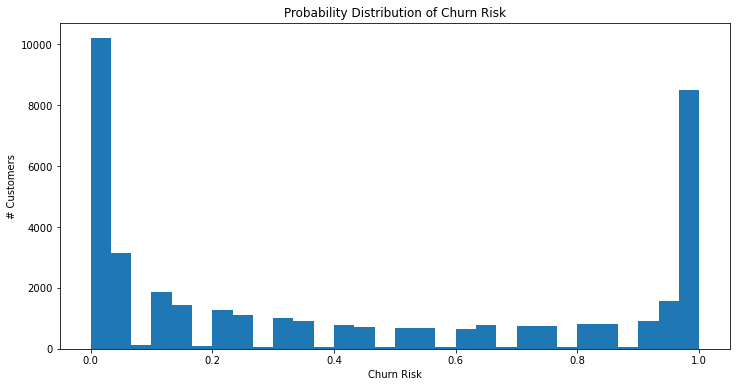

In [24]:
# Import the libraries
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
plt.figure(figsize=(12, 6))
# matplotlib histogram
plt.hist(probs, bins = int(180/6))

# # seaborn histogram
# sns.distplot(probs, hist=True, kde=False, 
#              bins=int(180/5), color = 'blue',
#              hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Probability Distribution of Churn Risk')
plt.xlabel('Churn Risk')
plt.ylabel('# Customers')
plt.show()

In [26]:
#Save the model
import pickle

# save the model to disk
filename = os.path.join('C:/Users/admin/Desktop/lecturr exams', 'churn_model.sav')
pickle.dump(rf, open(filename, 'wb'))